<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек,-загрузка-данных" data-toc-modified-id="Импорт-библиотек,-загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек, загрузка данных</a></span></li><li><span><a href="#Таблица-профилей-пользователей,-удержание,-LTV-по-неделям" data-toc-modified-id="Таблица-профилей-пользователей,-удержание,-LTV-по-неделям-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Таблица профилей пользователей, удержание, LTV по неделям</a></span><ul class="toc-item"><li><span><a href="#Визуализация-LTV" data-toc-modified-id="Визуализация-LTV-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Визуализация LTV</a></span></li></ul></li><li><span><a href="#Момент-и-горизонт-анализа" data-toc-modified-id="Момент-и-горизонт-анализа-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Момент и горизонт анализа</a></span></li><li><span><a href="#Прогноз-LTV`" data-toc-modified-id="Прогноз-LTV`-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Прогноз LTV`</a></span></li><li><span><a href="#Расчет-ROMI" data-toc-modified-id="Расчет-ROMI-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчет ROMI</a></span></li></ul></div>

**ТЕХНИЧЕСКОЕ ЗАДАНИЕ**

Приложение - мобильная утилита для сканирования документов.

Модель монетизации подписочная, есть пробный период 7 дней с дальнейшим переходом в оплату 4.99 USD в неделю.

**Исходные данные** - выгрузка с базы данных по оформленю подписок и оплат.

Каждая строка представлет собой отдельное событие (либо оформление пробной подписки либо оплата после завершения пробного периода)

1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ 
(cohorting event - оформление пробного периода, когорта представляет собой кол-во возможных операций)

2. Спрогнозировать каким будет LTV на полгода

3. Построить график, который будет отображать кривую фактического LTV на фоне кривой прогнозируемого LTV

4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский, цель: узнать как окупятся наши инвестиции).



## Импорт библиотек, загрузка данных

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta



In [2]:
try:
    df = pd.read_excel('*********')
except:
    df = pd.read_excel('*********')

In [3]:
df.sample(5)

,product_id,quantity,is_trial_period,purchase_date,user_id
84377,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-29,9082949
27072,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-03,9212240
37181,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-16,8715185
105211,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-30,9084708
89030,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-05,8449522


    Участников всех когорт изначально объединяет какое-нибудь событие. 
    Чаще всего это первое посещение сайта, регистрация или скачивание мобильного приложения. 
    Так в анализ попадает только определённая категория людей — впервые посетившие сайт, зарегистрированные в программе лояльности, пользователи приложения. 
    После этого их делят на когорты по выбранным признакам.

## Таблица профилей пользователей, удержание, LTV по неделям

In [4]:
def get_profilies(df, user_id, date_transaction, atrubut):
    '''Профили пользователей совершивших первый визит'''
    profilies = (df.sort_values(by = [user_id, date_transaction]).groupby(user_id)
     .agg({date_transaction:'first', atrubut:'first'}).rename(columns = {date_transaction:'first_visit'})
    .reset_index())

    profilies['dt'] = profilies['first_visit'].dt.date
    profilies['week'] = profilies['first_visit'].astype('datetime64[W]')
    profilies['month'] = profilies['first_visit'].astype('datetime64[M]')
    
    return profilies

In [5]:
profilies = get_profilies(df,'user_id','purchase_date','is_trial_period')
profilies

,user_id,first_visit,is_trial_period,dt,week,month
0,404,2020-02-03,True,2020-02-03,2020-01-30,2020-02-01
1,5337,2020-02-17,True,2020-02-17,2020-02-13,2020-02-01
2,9010,2020-01-27,True,2020-01-27,2020-01-23,2020-01-01
3,19880,2020-01-30,True,2020-01-30,2020-01-30,2020-01-01
4,23403,2020-01-20,True,2020-01-20,2020-01-16,2020-01-01
...,...,...,...,...,...,...
62904,9694642,2020-02-20,True,2020-02-20,2020-02-20,2020-02-01
62905,9694662,2020-02-20,True,2020-02-20,2020-02-20,2020-02-01
62906,9694699,2020-02-20,True,2020-02-20,2020-02-20,2020-02-01
62907,9694734,2020-02-20,True,2020-02-20,2020-02-20,2020-02-01


In [6]:
result_raw = profilies.merge(df[['user_id','purchase_date']], how = 'left', on ='user_id')
result_raw ['lifetime'] = (result_raw['purchase_date'] - result_raw ['first_visit']).dt.days
result_raw ['lifetime_week'] = round(result_raw ['lifetime']/7,0)
result_raw.head(5)

,user_id,first_visit,is_trial_period,dt,week,month,purchase_date,lifetime,lifetime_week
0,404,2020-02-03,True,2020-02-03,2020-01-30,2020-02-01,2020-02-03,0,0.0
1,404,2020-02-03,True,2020-02-03,2020-01-30,2020-02-01,2020-02-10,7,1.0
2,5337,2020-02-17,True,2020-02-17,2020-02-13,2020-02-01,2020-02-17,0,0.0
3,9010,2020-01-27,True,2020-01-27,2020-01-23,2020-01-01,2020-02-17,21,3.0
4,9010,2020-01-27,True,2020-01-27,2020-01-23,2020-01-01,2020-01-27,0,0.0


In [7]:
result_retation = result_raw.pivot_table(index = 'dt', columns = 'lifetime_week', values = 'user_id', aggfunc='nunique' )
result_retation.head(5)

lifetime_week,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
dt,,,,,,,,
2020-01-01,906.0,334.0,279.0,254.0,235.0,212.0,193.0,159.0
2020-01-02,1300.0,486.0,412.0,348.0,316.0,281.0,260.0,86.0
2020-01-03,1439.0,524.0,421.0,377.0,341.0,303.0,264.0,16.0
2020-01-04,1459.0,561.0,440.0,399.0,362.0,330.0,301.0,5.0
2020-01-05,1525.0,590.0,474.0,434.0,395.0,357.0,320.0,4.0


In [8]:
cohort_sizes = (
    result_raw.groupby('dt')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
).reset_index()

cohort_sizes.head(5)

,dt,cohort_size
0,2020-01-01,906
1,2020-01-02,1300
2,2020-01-03,1439
3,2020-01-04,1459
4,2020-01-05,1525


In [9]:
# объединяем размеры когорт и таблицу удержания
result_grouped = cohort_sizes.merge(
    result_retation, on='dt', how='left'
).fillna(0)

result_grouped.head(5)

,dt,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,2020-01-01,906,906.0,334.0,279.0,254.0,235.0,212.0,193.0,159.0
1,2020-01-02,1300,1300.0,486.0,412.0,348.0,316.0,281.0,260.0,86.0
2,2020-01-03,1439,1439.0,524.0,421.0,377.0,341.0,303.0,264.0,16.0
3,2020-01-04,1459,1459.0,561.0,440.0,399.0,362.0,330.0,301.0,5.0
4,2020-01-05,1525,1525.0,590.0,474.0,434.0,395.0,357.0,320.0,4.0


In [26]:
# делим данные таблицы удержания на размеры когорт

result_ltv= result_grouped.loc[:,'cohort_size':7.0].div(
    result_grouped['cohort_size'], axis=0).drop(columns=['cohort_size', 0.0])

result_ltv['dt'] = result_grouped['dt']
result_ltv = result_ltv.set_index('dt')
result_ltv.head(15)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0
dt,,,,,,,
2020-01-01,0.368653,0.307947,0.280353,0.259382,0.233996,0.213024,0.175497
2020-01-02,0.373846,0.316923,0.267692,0.243077,0.216154,0.200000,0.066154
2020-01-03,0.364142,0.292564,0.261987,0.236970,0.210563,0.183461,0.011119
2020-01-04,0.384510,0.301576,0.273475,0.248115,0.226182,0.206306,0.003427
2020-01-05,0.386885,0.310820,0.284590,0.259016,0.234098,0.209836,0.002623
2020-01-06,0.357616,0.275938,0.246505,0.224430,0.198675,0.173657,0.000000
2020-01-07,0.351261,0.288235,0.249580,0.224370,0.199160,0.157143,0.000000
2020-01-08,0.345471,0.282416,0.245115,0.228242,0.216696,0.166075,0.000000
2020-01-09,0.308970,0.260797,0.225083,0.198505,0.186877,0.056478,0.000000


### Визуализация LTV

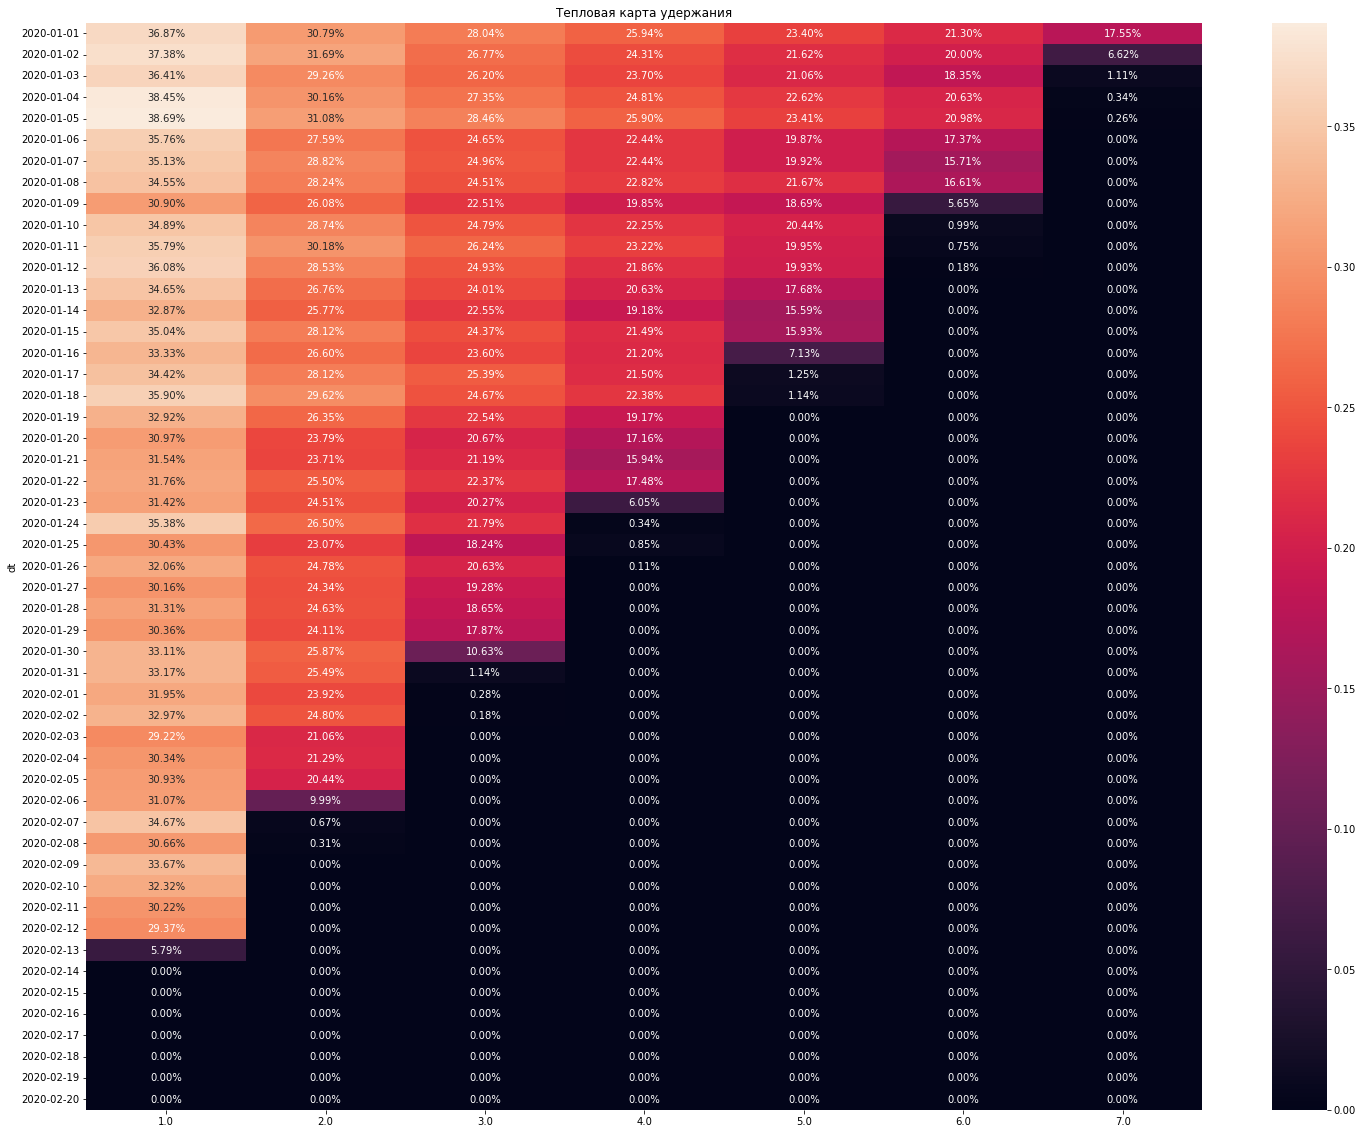

In [11]:
plt.figure(figsize =(25,20))
sns.heatmap(
    result_ltv,
    annot=True,
    fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

Конверсия удержания пользователей по первой недели в приложении составялет более 30% до 12-02-2020

На следующий день заметно резкое снижение до 5 % , а далее конверсия по пользованию приложения уходит в 0
 
Необходимо дать знать об этом разработчикам и проверить работоспособность приложения.

После завершения пробного периода (первая неделя) конверсия по пользователям остается довольно высокой от 20 до 30 %

Когорта пользователей от 2020-01-01 и 2020-01-02 самая надежная пробыла в приложении более 7 недель (LTV)

In [12]:
result_ltv.T

dt,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,...,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20
1.0,0.368653,0.373846,0.364142,0.384510,0.386885,0.357616,0.351261,0.345471,0.308970,0.348933,...,0.302158,0.293697,0.05791,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.307947,0.316923,0.292564,0.301576,0.310820,0.275938,0.288235,0.282416,0.260797,0.287356,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.280353,0.267692,0.261987,0.273475,0.284590,0.246505,0.249580,0.245115,0.225083,0.247947,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.259382,0.243077,0.236970,0.248115,0.259016,0.224430,0.224370,0.228242,0.198505,0.222496,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.233996,0.216154,0.210563,0.226182,0.234098,0.198675,0.199160,0.216696,0.186877,0.204433,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.213024,0.200000,0.183461,0.206306,0.209836,0.173657,0.157143,0.166075,0.056478,0.009852,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.175497,0.066154,0.011119,0.003427,0.002623,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


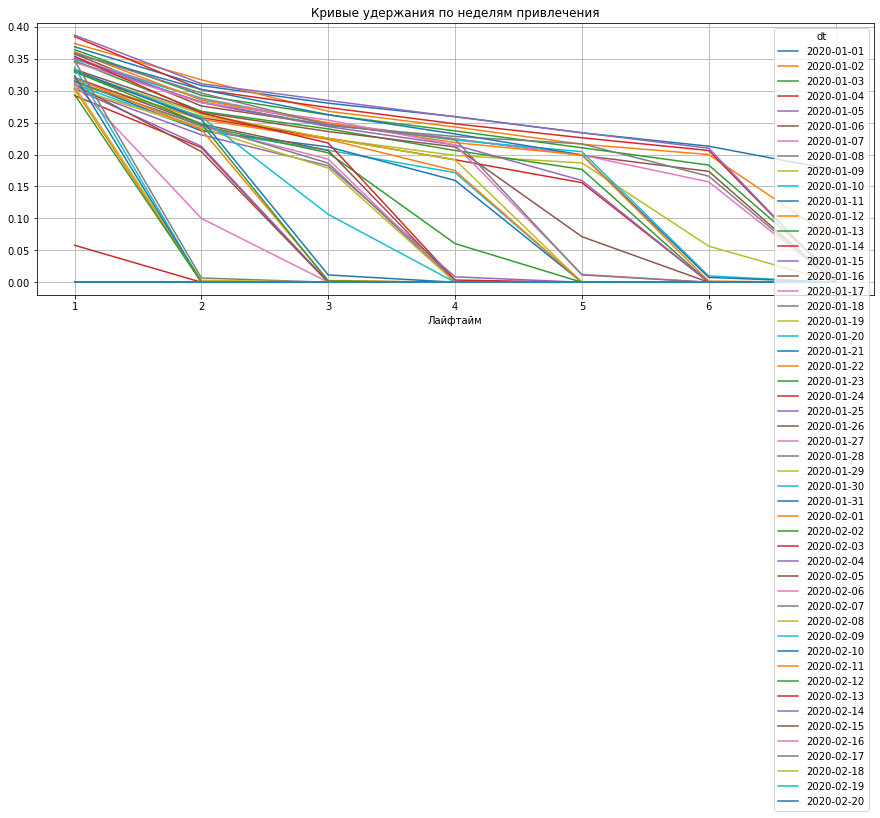

In [27]:
# строим кривые удержания

result_ltv.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(result_ltv.columns.values),  # отметки на оси X — названия колонок
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по неделям привлечения')  # название графика
plt.show()

Кривые удержания пользователей за каждый день представлены не наглядно, масштабируем их до недель или месяцев

In [28]:
result_ltv = result_ltv.reset_index()
result_ltv['month'] = result_ltv['dt'].astype('datetime64[M]')
result_ltv_month =result_ltv.groupby('month').sum()
result_ltv_month

,1.0,2.0,3.0,4.0,5.0,6.0,7.0
month,,,,,,,
2020-01-01,10.517148,8.387739,6.892492,4.830154,3.11288,1.585132,0.258819
2020-02-01,3.831776,1.224793,0.004567,0.000000,0.00000,0.000000,0.000000


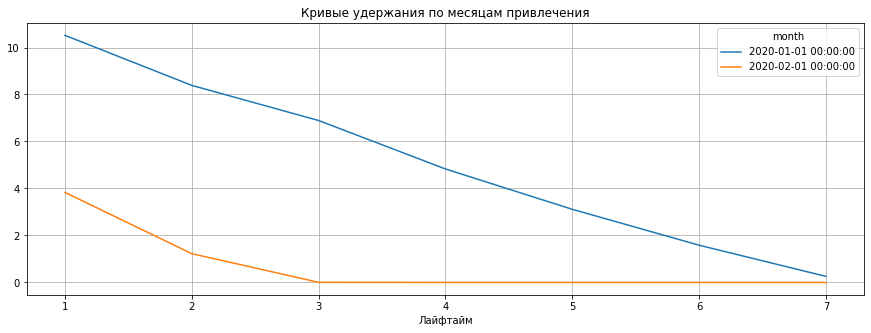

In [30]:
# строим кривые удержания

result_ltv_month.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(result_ltv_month.columns.values),  # отметки на оси X — названия колонок
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по месяцам привлечения')  # название графика
plt.show()

## Момент и горизонт анализа 

## Прогноз LTV`

## Расчет ROMI